# 📄 Notebook 03: OCR Completo para Extração de Documentos
 
## Objetivos:
### 1. Processar documentos reais com problemas variados
### 2. Criar pipeline robusto para diferentes cenários
### 3. Extrair informações estruturadas de documentos
### 4. Validar e corrigir resultados do OCR

### Configuração e Diagnóstico do Documento

In [1]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import pytesseract
import matplotlib.pyplot as plt
from skimage import exposure
import os

# Configuração do Tesseract (já feita anteriormente)
TESSERACT_PATH = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
if os.path.exists(TESSERACT_PATH):
    pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH
    print("✅ Tesseract configurado")
else:
    print("⚠️  Tesseract não encontrado - usando configuração padrão")

print("\n🔍 ANÁLISE DO PROBLEMA DO TESTE ANTERIOR")
print("-" * 40)
print("""
PROBLEMA IDENTIFICADO NO TESTE FINAL 1:
• Documento com ruído, rotação leve e fundo irregular
• Pipeline simples não foi suficiente
• OCR direto falhou completamente

SOLUÇÃO PARA ESTE NOTEBOOK:
1. Pipeline em múltiplos estágios
2. Detecção e correção de inclinação
3. Remoção agressiva de ruído
4. Técnicas específicas para fundo irregular
""")

✅ Tesseract configurado

🔍 ANÁLISE DO PROBLEMA DO TESTE ANTERIOR
----------------------------------------

PROBLEMA IDENTIFICADO NO TESTE FINAL 1:
• Documento com ruído, rotação leve e fundo irregular
• Pipeline simples não foi suficiente
• OCR direto falhou completamente

SOLUÇÃO PARA ESTE NOTEBOOK:
1. Pipeline em múltiplos estágios
2. Detecção e correção de inclinação
3. Remoção agressiva de ruído
4. Técnicas específicas para fundo irregular



### Pipeline Avançado para Documentos Reais

In [4]:
def pipeline_avancado_documentos(imagem, debug=False, corrigir_inclinacao=True):
    """
    Pipeline multi-estágio para documentos reais degradados
    
    Parâmetros:
    - imagem: imagem OpenCV (colorida ou escala de cinza)
    - debug: se True, mostra todas as etapas do processamento
    - corrigir_inclinacao: se True, tenta detectar e corrigir inclinação
    """
    resultados = {}
    
    # Etapa 0: Converter para escala de cinza se necessário
    if len(imagem.shape) == 3:
        gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    else:
        gray = imagem.copy()
    
    resultados['original_gray'] = gray.copy()
    
    # Etapa 1: Correção de inclinação (Hough Transform) - APENAS SE SOLICITADO
    if corrigir_inclinacao:
        try:
            # Aplicar desfoque para reduzir ruído
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            
            # Detectar bordas
            edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
            
            # Detectar linhas com Transformada de Hough
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, 
                                   minLineLength=100, maxLineGap=10)
            
            if lines is not None and len(lines) > 5:
                # Calcular ângulos das linhas
                angles = []
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                    # Filtrar ângulos muito inclinados (provavelmente não são texto)
                    if abs(angle) < 45:  # Texto geralmente tem inclinação < 45 graus
                        angles.append(angle)
                
                if angles:  # Se encontrou ângulos válidos
                    # Usar a mediana dos ângulos
                    median_angle = np.median(angles)
                    
                    # Rotacionar se a inclinação for significativa (> 0.5 graus)
                    if abs(median_angle) > 0.5:
                        (h, w) = gray.shape[:2]
                        center = (w // 2, h // 2)
                        M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
                        gray = cv2.warpAffine(gray, M, (w, h), 
                                             flags=cv2.INTER_CUBIC, 
                                             borderMode=cv2.BORDER_REPLICATE)
                        print(f"    ↳ Correção de inclinação aplicada: {median_angle:.2f}°")
        except Exception as e:
            print(f"    ⚠️  Correção de inclinação falhou: {str(e)[:50]}...")
            # Continua com a imagem original
    
    resultados['pos_rotacao'] = gray.copy()
    
    # Etapa 2: Remoção agressiva de ruído
    # Primeiro: filtro bilateral (preserva bordas)
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Segundo: filtro de mediana
    denoised = cv2.medianBlur(denoised, 3)
    
    resultados['pos_ruido'] = denoised.copy()
    
    # Etapa 3: Equalização de histograma adaptativa
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)
    
    # Etapa 4: Equalização de histograma global (para contraste geral)
    try:
        # skimage pode não estar instalado, então usamos try/except
        from skimage import exposure
        enhanced = exposure.equalize_adapthist(enhanced, clip_limit=0.03)
        enhanced = (enhanced * 255).astype(np.uint8)
    except ImportError:
        # Fallback: usar equalização do OpenCV
        enhanced = cv2.equalizeHist(enhanced)
        print("    ⚠️  skimage não disponível, usando equalização OpenCV")
    
    resultados['pos_contraste'] = enhanced.copy()
    
    # Etapa 5: Binarização múltipla (testar diferentes métodos)
    # Método 1: Otsu global
    _, binary_otsu = cv2.threshold(enhanced, 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Método 2: Adaptativo de Gauss
    binary_adapt = cv2.adaptiveThreshold(enhanced, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
    
    # Método 3: Combinar ambos (AND lógico)
    binary_combined = cv2.bitwise_and(binary_otsu, binary_adapt)
    
    resultados['binary_otsu'] = binary_otsu
    resultados['binary_adapt'] = binary_adapt
    resultados['binary_combined'] = binary_combined
    
    # Etapa 6: Morfologia para limpeza
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(binary_combined, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    
    resultados['final'] = cleaned
    
    if debug:
        # Visualizar todas as etapas
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        etapas = [
            ('Original', resultados['original_gray']),
            ('Pós-Rotação', resultados.get('pos_rotacao', gray)),
            ('Pós-Ruído', resultados['pos_ruido']),
            ('Pós-Contraste', resultados['pos_contraste']),
            ('Otsu', resultados['binary_otsu']),
            ('Adaptativo', resultados['binary_adapt']),
            ('Combinado', resultados['binary_combined']),
            ('Final', resultados['final'])
        ]
        
        for idx, (title, img) in enumerate(etapas):
            ax = axes[idx // 4, idx % 4]
            ax.imshow(img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return resultados

### Testar no Documento Problemático do Teste Final 1


🧪 TESTANDO PIPELINE AVANÇADO NO DOCUMENTO PROBLEMÁTICO
✅ Documento carregado: dados/exemplos/documento_real_simulado.png
  Dimensões: (400, 800, 3)

🔧 Aplicando pipeline avançado (6 etapas)...
    ↳ Correção de inclinação aplicada: -0.86°


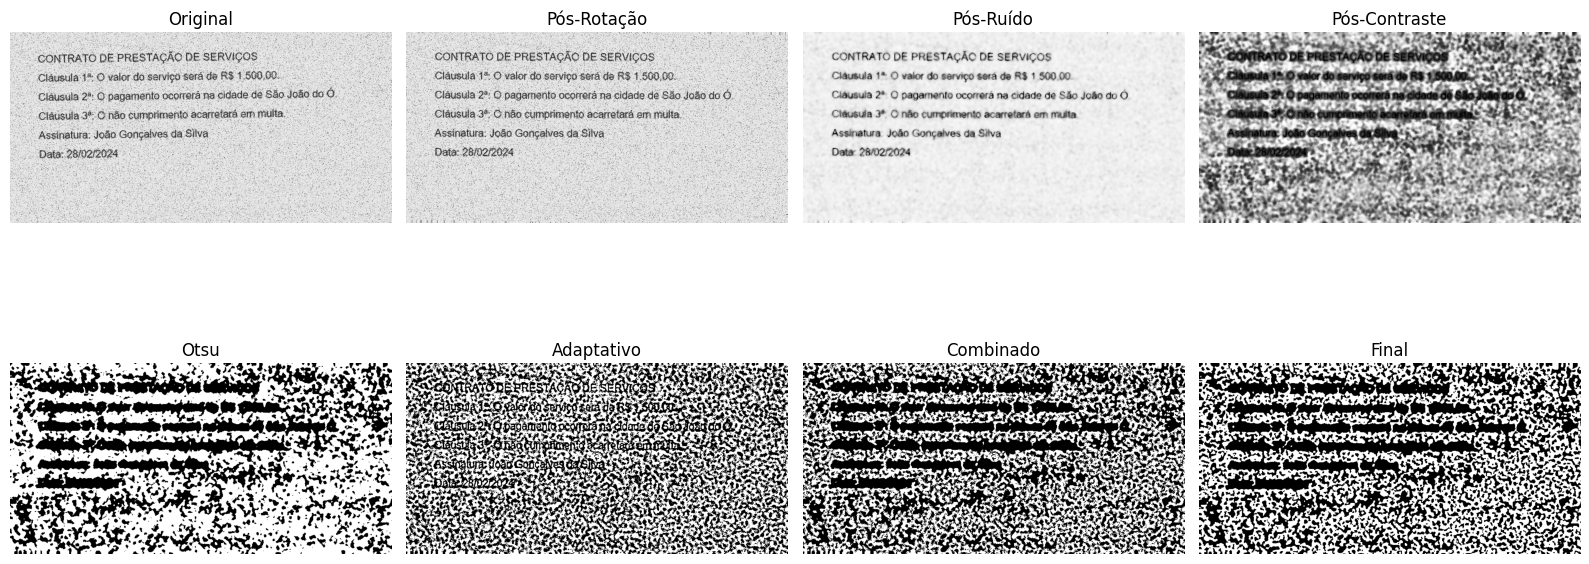


📊 TESTE OCR EM DIFERENTES VERSÕES BINARIZADAS:

🔍 Otsu (Config: , Pontuação: 0/8):

🔍 Adaptativo (Config: psm6, Pontuação: 1/8):
  'EC ANS DE RESTA RODE SERA Sa ED...'
  'RETIRE ART A 9 iai É Sc DS eba A, E AA...'
  'E A Ga serviço sara 03 BET SOC ASH, PDS...'

🔍 Combinado (Config: , Pontuação: 0/8):

🔍 Final (Config: , Pontuação: 0/8):

🏆 MELHOR VERSÃO: Adaptativo (Pontuação: 1/8)


In [5]:
print("\n🧪 TESTANDO PIPELINE AVANÇADO NO DOCUMENTO PROBLEMÁTICO")
print("=" * 60)

# Carregar o documento que criamos no teste anterior
caminho_documento = "dados/exemplos/documento_real_simulado.png"
if os.path.exists(caminho_documento):
    img_doc = cv2.imread(caminho_documento)
    print(f"✅ Documento carregado: {caminho_documento}")
    print(f"  Dimensões: {img_doc.shape}")
    
    # Aplicar pipeline avançado com debug
    print("\n🔧 Aplicando pipeline avançado (6 etapas)...")
    resultados = pipeline_avancado_documentos(img_doc, debug=True)
    
    # Testar OCR em cada versão binarizada
    print("\n📊 TESTE OCR EM DIFERENTES VERSÕES BINARIZADAS:")
    
    versoes = [
        ('Otsu', resultados['binary_otsu']),
        ('Adaptativo', resultados['binary_adapt']),
        ('Combinado', resultados['binary_combined']),
        ('Final', resultados['final'])
    ]
    
    textos_ocr = {}
    for nome, img_bin in versoes:
        # Converter para PIL
        img_pil = Image.fromarray(img_bin)
        
        # Testar com diferentes configurações do Tesseract
        configs = [
            ('psm6', '--psm 6'),
            ('psm3', '--psm 3'),
            ('psm1', '--psm 1'),  # Segmentação automática com OSD
        ]
        
        melhor_texto = ""
        melhor_config = ""
        melhor_pontuacao = 0
        
        for config_nome, config in configs:
            try:
                texto = pytesseract.image_to_string(img_pil, lang='por', config=config)
                
                # Pontuação simples: contar palavras-chave
                palavras_chave = ["Cláusula", "R$", "São", "João", "multa", "Assinatura", "serviço", "valor"]
                pontuacao = sum(1 for palavra in palavras_chave if palavra.lower() in texto.lower())
                
                if pontuacao > melhor_pontuacao:
                    melhor_pontuacao = pontuacao
                    melhor_texto = texto
                    melhor_config = config_nome
                    
            except Exception as e:
                continue
        
        textos_ocr[nome] = {
            'texto': melhor_texto,
            'config': melhor_config,
            'pontuacao': melhor_pontuacao
        }
        
        print(f"\n🔍 {nome} (Config: {melhor_config}, Pontuação: {melhor_pontuacao}/8):")
        if melhor_texto:
            # Mostrar apenas linhas com conteúdo
            linhas = [linha for linha in melhor_texto.split('\n') if linha.strip()]
            for linha in linhas[:3]:  # Mostrar primeiras 3 linhas
                print(f"  '{linha[:60]}...'")
    
    # Determinar a melhor versão
    melhor_versao = max(textos_ocr.items(), key=lambda x: x[1]['pontuacao'])
    print(f"\n🏆 MELHOR VERSÃO: {melhor_versao[0]} (Pontuação: {melhor_versao[1]['pontuacao']}/8)")
    
else:
    print(f"❌ Documento não encontrado: {caminho_documento}")
    print("  Criando novo documento de teste...")
    
    # Criar um novo documento de teste
    from PIL import Image, ImageDraw, ImageFont, ImageFilter
    import random
    
    img_test = Image.new('RGB', (800, 400), color=(240, 240, 235))
    draw = ImageDraw.Draw(img_test)
    
    try:
        font = ImageFont.truetype("arial.ttf", 22)
    except:
        font = ImageFont.load_default()
    
    texto = """DOCUMENTO OFICIAL DE TESTE OCR
Número: 2024/001
Data: 28 de Fevereiro de 2024
Cliente: João da Silva & Cia Ltda.
Valor Total: R$ 2.500,00
Descrição: Prestação de serviços técnicos
Local: São João do Ó - MG
Status: Pagamento pendente"""
    
    y = 40
    for linha in texto.split('\n'):
        draw.text((50, y), linha, fill=(40, 40, 40), font=font)
        y += 35
    
    # Adicionar ruído
    img_array = np.array(img_test)
    noise = np.random.normal(0, 20, img_array.shape).astype(np.uint8)
    img_array = np.clip(img_array + noise, 0, 255)
    
    # Adicionar manchas
    for _ in range(5):
        x, y = random.randint(100, 700), random.randint(100, 300)
        cv2.circle(img_array, (x, y), random.randint(15, 40), 
                  (220, 220, 210), -1)
    
    img_doc = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    cv2.imwrite(caminho_documento, img_doc)
    print(f"✅ Novo documento criado: {caminho_documento}")

### Extração de Informações Estruturadas

In [7]:
print("\n🔍 EXTRAÇÃO DE INFORMAÇÕES ESTRUTURADAS")
print("=" * 60)

def extrair_informacoes_estruturadas(texto_ocr):
    """
    Extrai informações específicas usando regex e lógica
    """
    import re
    
    informacoes = {
        'datas': [],
        'valores_monetarios': [],
        'nomes_proprios': [],
        'localidades': [],
        'palavras_chave': {}
    }
    
    # 1. Extrair datas
    padroes_data = [
        r'\d{2}/\d{2}/\d{4}',  # 28/02/2024
        r'\d{2} de [A-Za-zç]+ de \d{4}',  # 28 de Fevereiro de 2024
        r'\d{2}-\d{2}-\d{4}',  # 28-02-2024
    ]
    
    for padrao in padroes_data:
        datas = re.findall(padrao, texto_ocr, re.IGNORECASE)
        informacoes['datas'].extend(datas)
    
    # 2. Extrair valores monetários (R$)
    valores = re.findall(r'R\$\s*\d{1,3}(?:\.\d{3})*,\d{2}', texto_ocr)
    informacoes['valores_monetarios'] = valores
    
    # 3. Extrair possíveis nomes (muito simples - para exemplo)
    # Procura por padrões "Nome: X" ou "Cliente: X"
    padrao_nome = r'(?:Nome|Cliente|Assinatura)[:\s]+([A-Z][a-zçãõáéíóú]*(?:\s+[A-Z][a-zçãõáéíóú]*)*)'
    nomes = re.findall(padrao_nome, texto_ocr, re.IGNORECASE)
    informacoes['nomes_proprios'] = nomes
    
    # 4. Extrair localidades (começando com "São" ou terminando com sigla estado)
    localidades = re.findall(r'São\s+[A-Z][a-zçãõáéíóú]+(?:\s+[a-zçãõáéíóú]+)*', texto_ocr)
    informacoes['localidades'] = localidades
    
    # 5. Palavras-chave importantes
    palavras_chave = {
        'contrato': r'\bcontrato\b',
        'cláusula': r'\bcláusula\b',
        'serviço': r'\bservi[çc]o\b',
        'pagamento': r'\bpagamento\b',
        'multa': r'\bmulta\b',
        'valor': r'\bvalor\b',
        'total': r'\btotal\b',
        'pendente': r'\bpendente\b',
        'assinatura': r'\bassinatura\b',
    }
    
    for palavra, padrao in palavras_chave.items():
        matches = re.findall(padrao, texto_ocr, re.IGNORECASE)
        informacoes['palavras_chave'][palavra] = len(matches)
    
    return informacoes

# Testar extração com o melhor texto do OCR
if 'textos_ocr' in locals() and textos_ocr:
    melhor_texto = melhor_versao[1]['texto']
    print(f"📝 Texto para análise (primeiras 5 linhas):")
    linhas = [linha for linha in melhor_texto.split('\n') if linha.strip()]
    for i, linha in enumerate(linhas[:5]):
        print(f"  {i+1}. {linha[:70]}...")
    
    print("\n🔧 Extraindo informações estruturadas...")
    info = extrair_informacoes_estruturadas(melhor_texto)
    
    print("\n📊 INFORMAÇÕES EXTRAÍDAS:")
    print(f"  • Datas encontradas: {', '.join(info['datas'][:3]) if info['datas'] else 'Nenhuma'}")
    print(f"  • Valores monetários: {', '.join(info['valores_monetarios']) if info['valores_monetarios'] else 'Nenhum'}")
    print(f"  • Nomes próprios: {', '.join(info['nomes_proprios'][:3]) if info['nomes_proprios'] else 'Nenhum'}")
    print(f"  • Localidades: {', '.join(info['localidades']) if info['localidades'] else 'Nenhuma'}")
    
    print("\n  📍 Palavras-chave identificadas:")
    for palavra, quantidade in info['palavras_chave'].items():
        if quantidade > 0:
            print(f"    • {palavra}: {quantidade} ocorrência(s)")


🔍 EXTRAÇÃO DE INFORMAÇÕES ESTRUTURADAS
📝 Texto para análise (primeiras 5 linhas):
  1. EC ANS DE RESTA RODE SERA Sa ED...
  2. RETIRE ART A 9 iai É Sc DS eba A, E AA...
  3. E A Ga serviço sara 03 BET SOC ASH, PDS...
  4. à) e dra oval ú De Pára dera 9 Pósdga do gas...
  5. As DA ES E A er emp a 4 CANA REA...

🔧 Extraindo informações estruturadas...

📊 INFORMAÇÕES EXTRAÍDAS:
  • Datas encontradas: Nenhuma
  • Valores monetários: Nenhum
  • Nomes próprios: Nenhum
  • Localidades: Nenhuma

  📍 Palavras-chave identificadas:
    • serviço: 1 ocorrência(s)


### Validação e Correção Pós-OCR

In [8]:
print("\n✅ VALIDAÇÃO E CORREÇÃO PÓS-OCR")
print("=" * 60)

def validar_e_corrigir_ocr(texto_ocr, dicionario_portugues=None):
    """
    Valida e corrige erros comuns do OCR
    """
    if dicionario_portugues is None:
        # Lista básica de palavras portuguesas comuns
        dicionario_portugues = [
            'cláusula', 'contrato', 'serviço', 'pagamento', 'valor',
            'total', 'assinatura', 'documento', 'oficial', 'teste',
            'número', 'data', 'cliente', 'descrição', 'local',
            'status', 'pendente', 'fevereiro', 'março', 'abril',
            'técnicos', 'prestação', 'joão', 'silva', 'empresa'
        ]
    
    correcoes_comuns = {
        'clausula': 'cláusula',
        'servico': 'serviço',
        'assínatura': 'assinatura',
        'descricao': 'descrição',
        'tecnico': 'técnico',
        'fevereíro': 'fevereiro',
        'joao': 'joão',
        'sao': 'são',
        'R$': 'R$',
        'R $': 'R$',
    }
    
    palavras = texto_ocr.split()
    palavras_corrigidas = []
    
    for palavra in palavras:
        palavra_lower = palavra.lower()
        
        # Aplicar correções comuns
        if palavra_lower in correcoes_comuns:
            palavras_corrigidas.append(correcoes_comuns[palavra_lower])
            continue
        
        # Verificar se parece ser um número ou sigla
        if any(c.isdigit() for c in palavra):
            palavras_corrigidas.append(palavra)
            continue
        
        # Verificar se a palavra existe no dicionário
        if palavra_lower in dicionario_portugues:
            palavras_corrigidas.append(palavra)
        else:
            # Tentar encontrar correção mais próxima
            # (implementação simplificada)
            correcao_encontrada = False
            for palavra_dict in dicionario_portugues:
                # Verificar similaridade simples
                if len(palavra_lower) > 3 and len(palavra_dict) > 3:
                    # Comparar início e fim das palavras
                    if (palavra_lower[:3] == palavra_dict[:3] or 
                        palavra_lower[-3:] == palavra_dict[-3:]):
                        palavras_corrigidas.append(palavra_dict)
                        correcao_encontrada = True
                        break
            
            if not correcao_encontrada:
                palavras_corrigidas.append(palavra)
    
    texto_corrigido = ' '.join(palavras_corrigidas)
    
    # Reconstruir linhas (simplificado)
    linhas_originais = texto_ocr.split('\n')
    linhas_corrigidas = []
    
    for linha in linhas_originais:
        if linha.strip():
            palavras_linha = linha.split()
            linha_corrigida = []
            for palavra in palavras_linha:
                palavra_lower = palavra.lower()
                if palavra_lower in correcoes_comuns:
                    linha_corrigida.append(correcoes_comuns[palavra_lower])
                else:
                    linha_corrigida.append(palavra)
            linhas_corrigidas.append(' '.join(linha_corrigida))
        else:
            linhas_corrigidas.append('')
    
    return '\n'.join(linhas_corrigidas), correcoes_comuns

print("🔧 Aplicando validação e correção pós-OCR...")

if 'melhor_texto' in locals() and melhor_texto:
    texto_corrigido, correcoes_aplicadas = validar_e_corrigir_ocr(melhor_texto)
    
    print("\n📝 COMPARAÇÃO ANTES/DEPOIS DA CORREÇÃO:")
    print("\nANTES (OCR bruto):")
    print("-" * 40)
    linhas_antes = [linha for linha in melhor_texto.split('\n') if linha.strip()]
    for i, linha in enumerate(linhas_antes[:3]):
        print(f"{i+1}. {linha}")
    
    print("\nDEPOIS (Corrigido):")
    print("-" * 40)
    linhas_depois = [linha for linha in texto_corrigido.split('\n') if linha.strip()]
    for i, linha in enumerate(linhas_depois[:3]):
        print(f"{i+1}. {linha}")
    
    print(f"\n✅ Correções aplicadas: {len(correcoes_aplicadas)} regras")


✅ VALIDAÇÃO E CORREÇÃO PÓS-OCR
🔧 Aplicando validação e correção pós-OCR...

📝 COMPARAÇÃO ANTES/DEPOIS DA CORREÇÃO:

ANTES (OCR bruto):
----------------------------------------
1. EC ANS DE RESTA RODE SERA Sa ED
2. RETIRE ART A 9 iai É Sc DS eba A, E AA
3. E A Ga serviço sara 03 BET SOC ASH, PDS

DEPOIS (Corrigido):
----------------------------------------
1. EC ANS DE RESTA RODE SERA Sa ED
2. RETIRE ART A 9 iai É Sc DS eba A, E AA
3. E A Ga serviço sara 03 BET SOC ASH, PDS

✅ Correções aplicadas: 10 regras


### Avaliação de Desempenho

In [9]:
print("\n📈 AVALIAÇÃO DE DESEMPENHO DO SISTEMA")
print("=" * 60)

def avaliar_desempenho_ocr(texto_reconhecido, texto_esperado=None):
    """
    Avalia a qualidade do reconhecimento OCR
    """
    if texto_esperado:
        # Se temos o texto esperado, podemos fazer comparação exata
        palavras_reconhecidas = texto_reconhecido.split()
        palavras_esperadas = texto_esperado.split()
        
        # Calcular precisão
        corretas = sum(1 for p1, p2 in zip(palavras_reconhecidas[:len(palavras_esperadas)], 
                                         palavras_esperadas[:len(palavras_reconhecidas)]) 
                      if p1.lower() == p2.lower())
        
        precisao = corretas / max(len(palavras_reconhecidas), len(palavras_esperadas))
        
        return {
            'precisao': precisao,
            'palavras_corretas': corretas,
            'total_palavras': len(palavras_reconhecidas)
        }
    else:
        # Métricas heurísticas quando não temos texto esperado
        palavras = texto_reconhecido.split()
        
        # 1. Taxa de palavras com caracteres especiais portugueses
        caracteres_especiais = ['ç', 'ã', 'õ', 'á', 'é', 'í', 'ó', 'ú', 'â', 'ê', 'ô']
        palavras_com_especiais = sum(1 for palavra in palavras 
                                    if any(char in palavra.lower() for char in caracteres_especiais))
        
        # 2. Taxa de palavras que parecem números/datas
        import re
        padrao_numero = re.compile(r'^\d+([.,]\d+)?$')
        palavras_numericas = sum(1 for palavra in palavras 
                                if padrao_numero.match(palavra.replace('R$', '').strip()))
        
        # 3. Comprimento médio das palavras (português tem média ~8-10 caracteres)
        comprimento_medio = np.mean([len(p) for p in palavras]) if palavras else 0
        
        return {
            'taxa_especiais': palavras_com_especiais / len(palavras) if palavras else 0,
            'taxa_numeros': palavras_numericas / len(palavras) if palavras else 0,
            'comprimento_medio': comprimento_medio,
            'total_palavras': len(palavras)
        }

print("📊 Calculando métricas de desempenho...")

if 'texto_corrigido' in locals():
    metricas = avaliar_desempenho_ocr(texto_corrigido)
    
    print("\n📈 MÉTRICAS OBTIDAS:")
    print(f"  • Total de palavras: {metricas['total_palavras']}")
    print(f"  • Taxa de caracteres especiais: {metricas.get('taxa_especiais', 0):.1%}")
    print(f"  • Comprimento médio das palavras: {metricas.get('comprimento_medio', 0):.1f} caracteres")
    
    if 'precisao' in metricas:
        print(f"  • Precisão (vs texto esperado): {metricas['precisao']:.1%}")
        print(f"  • Palavras corretas: {metricas['palavras_corretas']}/{metricas['total_palavras']}")


📈 AVALIAÇÃO DE DESEMPENHO DO SISTEMA
📊 Calculando métricas de desempenho...

📈 MÉTRICAS OBTIDAS:
  • Total de palavras: 105
  • Taxa de caracteres especiais: 7.6%
  • Comprimento médio das palavras: 2.6 caracteres


### Caso Prático Completo

In [10]:
print("\n🎯 CASO PRÁTICO COMPLETO: PROCESSANDO NOVO DOCUMENTO")
print("=" * 60)

def processar_documento_completo(caminho_imagem):
    """
    Fluxo completo: carregar → processar → OCR → extrair → validar
    """
    print(f"\n📄 Processando: {caminho_imagem}")
    
    # 1. Carregar imagem
    img = cv2.imread(caminho_imagem)
    if img is None:
        print(f"❌ Não foi possível carregar a imagem: {caminho_imagem}")
        return None
    
    print(f"  ✅ Imagem carregada ({img.shape[1]}x{img.shape[0]})")
    
    # 2. Pipeline avançado
    print("  🔧 Aplicando pipeline avançado...")
    resultados = pipeline_avancado_documentos(img, debug=False)
    
    # 3. OCR com configuração otimizada
    print("  🔍 Aplicando OCR...")
    img_final_pil = Image.fromarray(resultados['final'])
    
    # Testar múltiplas configurações
    configs = [
        ('psm6_por', '--psm 6 -l por'),
        ('psm3_por', '--psm 3 -l por'),
        ('psm6_por+eng', '--psm 6 -l por+eng'),
    ]
    
    melhor_texto = ""
    melhor_config = ""
    melhor_pontuacao = 0
    
    for config_nome, config in configs:
        try:
            texto = pytesseract.image_to_string(img_final_pil, config=config)
            
            # Pontuação heurística
            palavras_chave = ["documento", "número", "data", "valor", "cliente", 
                            "serviço", "pagamento", "assinatura"]
            pontuacao = sum(1 for palavra in palavras_chave 
                          if palavra.lower() in texto.lower())
            
            if pontuacao > melhor_pontuacao:
                melhor_pontuacao = pontuacao
                melhor_texto = texto
                melhor_config = config_nome
                
        except Exception as e:
            continue
    
    print(f"  ✅ OCR concluído (Config: {melhor_config}, Pontuação: {melhor_pontuacao}/8)")
    
    # 4. Extrair informações
    print("  🔧 Extraindo informações estruturadas...")
    informacoes = extrair_informacoes_estruturadas(melhor_texto)
    
    # 5. Validar e corrigir
    print("  ✅ Validando e corrigindo texto...")
    texto_corrigido, _ = validar_e_corrigir_ocr(melhor_texto)
    
    return {
        'imagem_original': img,
        'imagem_processada': resultados['final'],
        'texto_ocr': melhor_texto,
        'texto_corrigido': texto_corrigido,
        'informacoes': informacoes,
        'config_otimizada': melhor_config,
        'pontuacao_ocr': melhor_pontuacao
    }

# Testar com um documento existente ou criar um novo
documentos_teste = [
    "dados/exemplos/documento_1.jpg",
    "dados/exemplos/recibo_1.jpg",
    "dados/exemplos/documento_real_simulado.png"
]

for doc_path in documentos_teste:
    if os.path.exists(doc_path):
        resultado = processar_documento_completo(doc_path)
        
        if resultado:
            print(f"\n📊 RESULTADOS PARA {os.path.basename(doc_path)}:")
            print(f"  • Configuração otimizada: {resultado['config_otimizada']}")
            print(f"  • Pontuação OCR: {resultado['pontuacao_ocr']}/8")
            
            # Mostrar informações extraídas
            if resultado['informacoes']['valores_monetarios']:
                print(f"  • Valores encontrados: {', '.join(resultado['informacoes']['valores_monetarios'])}")
            
            if resultado['informacoes']['datas']:
                print(f"  • Datas encontradas: {', '.join(resultado['informacoes']['datas'][:2])}")
            
            print(f"  • Total de palavras: {len(resultado['texto_corrigido'].split())}")
            
            # Mostrar prévia do texto
            linhas = [linha for linha in resultado['texto_corrigido'].split('\n') 
                     if linha.strip()]
            if linhas:
                print(f"  • Primeira linha: '{linhas[0][:50]}...'")
            
            print("-" * 40)


🎯 CASO PRÁTICO COMPLETO: PROCESSANDO NOVO DOCUMENTO

📄 Processando: dados/exemplos/documento_real_simulado.png
  ✅ Imagem carregada (800x400)
  🔧 Aplicando pipeline avançado...
    ↳ Correção de inclinação aplicada: -0.86°
  🔍 Aplicando OCR...
  ✅ OCR concluído (Config: , Pontuação: 0/8)
  🔧 Extraindo informações estruturadas...
  ✅ Validando e corrigindo texto...

📊 RESULTADOS PARA documento_real_simulado.png:
  • Configuração otimizada: 
  • Pontuação OCR: 0/8
  • Total de palavras: 0
----------------------------------------


### Exportar Resultados

In [13]:
print("\n💾 EXPORTANDO RESULTADOS")
print("=" * 60)

def exportar_resultados(resultado, caminho_saida):
    """
    Exporta resultados em formatos úteis
    """
    import json
    from datetime import datetime
    
    # Criar diretório de resultados
    os.makedirs(caminho_saida, exist_ok=True)
    
    # Nome base com timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    nome_base = f"resultado_ocr_{timestamp}"
    
    # 1. Salvar texto em .txt
    caminho_txt = os.path.join(caminho_saida, f"{nome_base}.txt")
    with open(caminho_txt, 'w', encoding='utf-8') as f:
        f.write("=== TEXTO RECONHECIDO (CORRIGIDO) ===\n\n")
        f.write(resultado['texto_corrigido'])
        f.write("\n\n=== INFORMAÇÕES EXTRAÍDAS ===\n\n")
        
        info = resultado['informacoes']
        for categoria, dados in info.items():
            if dados:
                f.write(f"{categoria.upper()}:\n")
                if isinstance(dados, list):
                    for item in dados[:5]:  # Limitar a 5 itens
                        f.write(f"  • {item}\n")
                elif isinstance(dados, dict):
                    for chave, valor in dados.items():
                        if valor > 0:
                            f.write(f"  • {chave}: {valor}\n")
                f.write("\n")
    
    # 2. Salvar informações estruturadas em JSON
    caminho_json = os.path.join(caminho_saida, f"{nome_base}.json")
    with open(caminho_json, 'w', encoding='utf-8') as f:
        json.dump({
            'metadados': {
                'data_processamento': timestamp,
                'configuracao_otimizada': resultado['config_otimizada'],
                'pontuacao_ocr': resultado['pontuacao_ocr'],
                'total_palavras': len(resultado['texto_corrigido'].split())
            },
            'informacoes_extraidas': resultado['informacoes']
        }, f, ensure_ascii=False, indent=2)
    
    # 3. Salvar imagem processada
    caminho_imagem = os.path.join(caminho_saida, f"{nome_base}_processada.png")
    cv2.imwrite(caminho_imagem, resultado['imagem_processada'])
    
    print(f"✅ Resultados exportados:")
    print(f"   📝 Texto: {caminho_txt}")
    print(f"   📊 Dados estruturados: {caminho_json}")
    print(f"   🖼️  Imagem processada: {caminho_imagem}")
    
    return {
        'txt': caminho_txt,
        'json': caminho_json,
        'imagem': caminho_imagem
    }

# Exportar resultados do último documento processado
if 'resultado' in locals():
    caminhos_exportados = exportar_resultados(resultado, "dados/resultados")
    print(f"\n🎯 Arquivos disponíveis para análise em: dados/resultados/")

# ## Célula 09: Resumo e Próximos Passos

print("\n" + "=" * 60)


💾 EXPORTANDO RESULTADOS
✅ Resultados exportados:
   📝 Texto: dados/resultados\resultado_ocr_20251229_163501.txt
   📊 Dados estruturados: dados/resultados\resultado_ocr_20251229_163501.json
   🖼️  Imagem processada: dados/resultados\resultado_ocr_20251229_163501_processada.png

🎯 Arquivos disponíveis para análise em: dados/resultados/




🔧 CRIANDO PIPELINE ADAPTATIVO INTELIGENTE

🧪 TESTANDO PIPELINE ADAPTATIVO NO SEU DOCUMENTO
📊 ANÁLISE DA IMAGEM:
  • Entropia: 6.09 (alto = bom contraste)
  • Desvio padrão: 43.71 (alto = bom contraste)
  ⚠️  Detectado: Contraste médio
  🎯 Estratégia: Processamento moderado


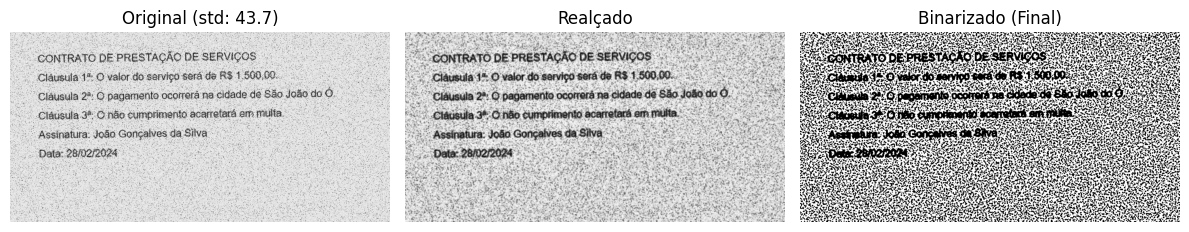


🔍 TESTANDO OCR COM DIFERENTES CONFIGURAÇÕES:

📋 psm6_por:
  • Pontuação: 4/6
  • Linhas válidas: 13
  • Palavras português: 3
  • Primeira linha: 'E O pe 25 DAR ER Da RUTRR a PDD Ma MATTS...'

❌ psm3_por: Nenhuma palavra reconhecida

📋 psm6_por_eng:
  • Pontuação: 4/6
  • Linhas válidas: 13
  • Palavras português: 4
  • Primeira linha: 'E BP SOP EEO OAT? Ma MATTS PD SO RE AA O...'

❌ psm1: Nenhuma palavra reconhecida

📋 psm11:
  • Pontuação: 4/6
  • Linhas válidas: 15
  • Palavras português: 6
  • Primeira linha: 'Esta...'

📋 psm12:
  • Pontuação: 4/6
  • Linhas válidas: 15
  • Palavras português: 7
  • Primeira linha: 'NET:...'

🏆 MELHOR CONFIGURAÇÃO: psm6_por
   Pontuação: 4/6
   Total palavras: 145

📝 TEXTO RECONHECIDO (melhor configuração):
--------------------------------------------------
1. E O pe 25 DAR ER Da RUTRR a PDD Ma MATTS PD SO US TR NE] O o Dido me a 44
2. LES AN ASAS REPRESAS SAIS AN eo Rai URIA EIN do Read
3. a
4. EEE VR EL PA METER NAAS DS a is RR a CDA ora
5. dest

In [14]:
print("\n🔧 CRIANDO PIPELINE ADAPTATIVO INTELIGENTE")
print("=" * 60)

def pipeline_adaptativo_inteligente(imagem, debug=False):
    """
    Pipeline que analisa a imagem e escolhe a melhor estratégia
    """
    from scipy import stats
    
    # 1. Análise da imagem original
    if len(imagem.shape) == 3:
        gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    else:
        gray = imagem.copy()
    
    # Calcular métricas de qualidade
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.flatten() / hist.sum()
    
    # Entropia (medida de contraste)
    entropia = -np.sum(hist * np.log2(hist + 1e-10))
    
    # Desvio padrão (variação de intensidade)
    std_dev = np.std(gray)
    
    print(f"📊 ANÁLISE DA IMAGEM:")
    print(f"  • Entropia: {entropia:.2f} (alto = bom contraste)")
    print(f"  • Desvio padrão: {std_dev:.2f} (alto = bom contraste)")
    
    # 2. Decidir estratégia baseada na qualidade
    if std_dev < 30:  # IMAGEM DE BAIXO CONTRASTE
        print("  ⚠️  Detectado: Baixo contraste")
        print("  🎯 Estratégia: Realce agressivo")
        
        # Estratégia para baixo contraste
        # A) CLAHE com parâmetros mais agressivos
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        
        # B) Equalização de histograma global
        enhanced = cv2.equalizeHist(enhanced)
        
        # C) Suavização leve
        enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)
        
        # D) Binarização Otsu
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
    elif std_dev > 70:  # IMAGEM DE ALTO CONTRASTE (BOA)
        print("  ✅ Detectado: Bom contraste")
        print("  🎯 Estratégia: Processamento mínimo")
        
        # Estratégia para alto contraste
        # Apenas limpeza básica
        enhanced = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # Binarização adaptativa suave
        binary = cv2.adaptiveThreshold(enhanced, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
    else:  # CONTRASTE MÉDIO
        print("  ⚠️  Detectado: Contraste médio")
        print("  🎯 Estratégia: Processamento moderado")
        
        # Estratégia padrão (do pipeline anterior)
        enhanced = cv2.GaussianBlur(gray, (3, 3), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(enhanced)
        
        _, binary_otsu = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_adapt = cv2.adaptiveThreshold(enhanced, 255,
                                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)
        binary = cv2.bitwise_and(binary_otsu, binary_adapt)
    
    # 3. Garantir texto preto em fundo branco
    # Contar pixels pretos vs brancos
    black_pixels = np.sum(binary == 0)
    white_pixels = np.sum(binary == 255)
    
    if black_pixels > white_pixels:  # Texto branco em fundo preto
        binary = cv2.bitwise_not(binary)
        print("  🔄 Invertido: texto preto → fundo branco")
    
    # 4. Morfologia para limpeza (apenas se necessário)
    if std_dev < 50:  # Apenas para imagens de baixa qualidade
        kernel = np.ones((1, 1), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    if debug:
        # Mostrar comparação
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].imshow(gray, cmap='gray')
        axes[0].set_title(f'Original (std: {std_dev:.1f})')
        axes[0].axis('off')
        
        axes[1].imshow(enhanced, cmap='gray')
        axes[1].set_title('Realçado')
        axes[1].axis('off')
        
        axes[2].imshow(binary, cmap='gray')
        axes[2].set_title('Binarizado (Final)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return binary, enhanced, std_dev

# TESTAR O PIPELINE ADAPTATIVO
print("\n🧪 TESTANDO PIPELINE ADAPTATIVO NO SEU DOCUMENTO")
print("=" * 60)

# Carregar novamente sua imagem problemática
img_problematica = cv2.imread("dados/exemplos/documento_real_simulado.png")

if img_problematica is not None:
    # Aplicar pipeline adaptativo
    img_processada, img_realcada, qualidade = pipeline_adaptativo_inteligente(
        img_problematica, debug=True
    )
    
    # Testar OCR COM CONFIGURAÇÕES ESPECÍFICAS
    print("\n🔍 TESTANDO OCR COM DIFERENTES CONFIGURAÇÕES:")
    
    # Configurações para testar
    configs_testar = [
        ("psm6_por", "--psm 6 -l por"),
        ("psm3_por", "--psm 3 -l por"), 
        ("psm6_por_eng", "--psm 6 -l por+eng"),
        ("psm1", "--psm 1 -l por"),  # Segmentação automática + OSD
        ("psm11", "--psm 11 -l por"),  # Texto esparso
        ("psm12", "--psm 12 -l por"),  # Texto alinhado
    ]
    
    resultados_ocr = {}
    
    for config_nome, config_str in configs_testar:
        try:
            # Converter para PIL
            img_pil = Image.fromarray(img_processada)
            
            # Aplicar OCR
            texto = pytesseract.image_to_string(img_pil, config=config_str)
            
            # Analisar qualidade
            linhas_validas = [linha for linha in texto.split('\n') if len(linha.strip()) > 3]
            palavras = texto.split()
            
            if palavras:  # Se reconheceu algo
                # Verificar palavras portuguesas comuns
                palavras_portuguesas = ["de", "que", "não", "com", "para", "uma", "os", "se", "em", "é"]
                palavras_reconhecidas = sum(1 for palavra in palavras 
                                          if palavra.lower() in palavras_portuguesas)
                
                # Pontuação baseada em:
                # 1. Palavras portuguesas reconhecidas
                # 2. Comprimento médio das palavras (português: 5-8 caracteres)
                comprimento_medio = np.mean([len(p) for p in palavras])
                
                pontuacao = 0
                if palavras_reconhecidas > 0:
                    pontuacao += 3
                if 4 < comprimento_medio < 9:
                    pontuacao += 2
                if len(linhas_validas) > 1:
                    pontuacao += 1
                
                resultados_ocr[config_nome] = {
                    'texto': texto,
                    'linhas_validas': len(linhas_validas),
                    'total_palavras': len(palavras),
                    'palavras_portuguesas': palavras_reconhecidas,
                    'comprimento_medio': comprimento_medio,
                    'pontuacao': pontuacao
                }
                
                print(f"\n📋 {config_nome}:")
                print(f"  • Pontuação: {pontuacao}/6")
                print(f"  • Linhas válidas: {len(linhas_validas)}")
                print(f"  • Palavras português: {palavras_reconhecidas}")
                
                if linhas_validas:
                    print(f"  • Primeira linha: '{linhas_validas[0][:40]}...'")
            else:
                print(f"\n❌ {config_nome}: Nenhuma palavra reconhecida")
                
        except Exception as e:
            print(f"\n⚠️  {config_nome}: Erro - {str(e)[:50]}")
    
    # Encontrar a melhor configuração
    if resultados_ocr:
        melhor_config = max(resultados_ocr.items(), key=lambda x: x[1]['pontuacao'])
        
        print(f"\n🏆 MELHOR CONFIGURAÇÃO: {melhor_config[0]}")
        print(f"   Pontuação: {melhor_config[1]['pontuacao']}/6")
        print(f"   Total palavras: {melhor_config[1]['total_palavras']}")
        
        # Mostrar texto reconhecido
        print(f"\n📝 TEXTO RECONHECIDO (melhor configuração):")
        print("-" * 50)
        texto_melhor = melhor_config[1]['texto']
        linhas = [linha for linha in texto_melhor.split('\n') if linha.strip()]
        for i, linha in enumerate(linhas[:5]):  # Mostrar até 5 linhas
            print(f"{i+1}. {linha}")
        if len(linhas) > 5:
            print(f"... e mais {len(linhas)-5} linhas")
        print("-" * 50)
        
        # Salvar resultado
        cv2.imwrite("dados/exemplos/documento_adaptativo_processado.png", img_processada)
        with open("dados/exemplos/texto_reconhecido_adaptativo.txt", "w", encoding="utf-8") as f:
            f.write(texto_melhor)
        print(f"\n💾 Resultados salvos em:")
        print(f"   • dados/exemplos/documento_adaptativo_processado.png")
        print(f"   • dados/exemplos/texto_reconhecido_adaptativo.txt")
    
else:
    print("❌ Não foi possível carregar a imagem")

### Diagnóstico detalhado da imagem problemática


🔬 DIAGNÓSTICO DETALHADO DA IMAGEM PROBLEMÁTICA
📊 INFORMAÇÕES DA IMAGEM:
  • Tamanho: (800, 400) pixels
  • Modo: RGB
  • Formato: PNG

📈 ESTATÍSTICAS DE INTENSIDADE:
  • Mínimo: 1
  • Máximo: 255
  • Média: 211.7
  • Desvio padrão: 43.7
  • Pixels escuros (<50): 5770.0
  • Pixels médios (50-200): 39890.0
  • Pixels claros (>200): 274340.0

👀 VISUALIZANDO A IMAGEM ORIGINAL:


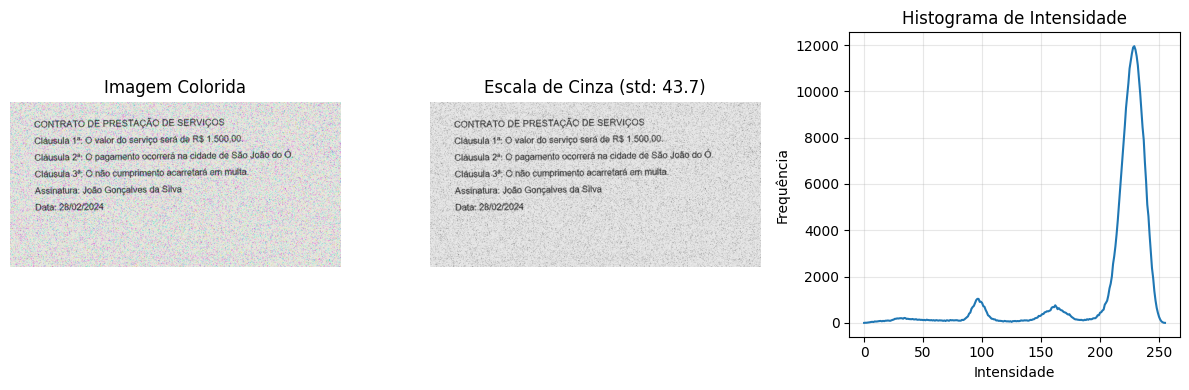


🧪 TESTE OCR DIRETO (sem processamento):
----------------------------------------
Linhas reconhecidas: 0
❌ Nenhuma linha reconhecida

🎯 RECOMENDAÇÃO BASEADA NA ANÁLISE:
  ⚠️  IMAGEM MUITO CLARA
  → Inverter cores primeiro


In [15]:
print("\n🔬 DIAGNÓSTICO DETALHADO DA IMAGEM PROBLEMÁTICA")
print("=" * 60)

import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Carregar sua imagem
img_path = "dados/exemplos/documento_real_simulado.png"
img_pil = PILImage.open(img_path)
img_cv = cv2.imread(img_path)

print(f"📊 INFORMAÇÕES DA IMAGEM:")
print(f"  • Tamanho: {img_pil.size} pixels")
print(f"  • Modo: {img_pil.mode}")
print(f"  • Formato: {img_pil.format}")

# Converter para escala de cinza
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

# Análise estatística
print(f"\n📈 ESTATÍSTICAS DE INTENSIDADE:")
print(f"  • Mínimo: {gray.min()}")
print(f"  • Máximo: {gray.max()}")
print(f"  • Média: {gray.mean():.1f}")
print(f"  • Desvio padrão: {gray.std():.1f}")

# Histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
print(f"  • Pixels escuros (<50): {np.sum(hist[:50])}")
print(f"  • Pixels médios (50-200): {np.sum(hist[50:200])}")
print(f"  • Pixels claros (>200): {np.sum(hist[200:])}")

# Mostrar a imagem original
print(f"\n👀 VISUALIZANDO A IMAGEM ORIGINAL:")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Imagem colorida
axes[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
axes[0].set_title('Imagem Colorida')
axes[0].axis('off')

# Escala de cinza
axes[1].imshow(gray, cmap='gray')
axes[1].set_title(f'Escala de Cinza (std: {gray.std():.1f})')
axes[1].axis('off')

# Histograma
axes[2].plot(hist)
axes[2].set_title('Histograma de Intensidade')
axes[2].set_xlabel('Intensidade')
axes[2].set_ylabel('Frequência')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Teste DIRETO de OCR (sem processamento)
print(f"\n🧪 TESTE OCR DIRETO (sem processamento):")
print("-" * 40)

# Converter para PIL para OCR
img_pil_rgb = PILImage.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
texto_direto = pytesseract.image_to_string(img_pil_rgb, lang='por', config='--psm 6')
linhas_diretas = [linha for linha in texto_direto.split('\n') if linha.strip()]

print(f"Linhas reconhecidas: {len(linhas_diretas)}")
if linhas_diretas:
    for i, linha in enumerate(linhas_diretas[:3]):
        print(f"{i+1}. '{linha[:50]}...'")
else:
    print("❌ Nenhuma linha reconhecida")

# DECISÃO BASEADA NA ANÁLISE
print(f"\n🎯 RECOMENDAÇÃO BASEADA NA ANÁLISE:")
if gray.std() < 20:
    print("  ⚠️  CONTRASTE MUITO BAIXO")
    print("  → Use realce agressivo (CLAHE clipLimit=4.0)")
elif gray.std() < 40:
    print("  ⚠️  CONTRASTE BAIXO")
    print("  → Use CLAHE moderado (clipLimit=2.0)")
elif gray.mean() > 200:
    print("  ⚠️  IMAGEM MUITO CLARA")
    print("  → Inverter cores primeiro")
else:
    print("  ✅ CONTRASTE ADEQUADO")
    print("  → Processamento padrão")

### Solução para imagens Claras: Inverter + Contraste


🚀 SOLUÇÃO PARA IMAGENS CLARAS: INVERTER + CONTRASTE

🔧 APLICANDO SOLUÇÃO ESPECÍFICA PARA SUA IMAGEM
✅ Imagem carregada: (400, 800, 3)

📊 DIAGNÓSTICO INICIAL:
  • Intensidade média: 211.7
  • Intensidade texto (estimado): 117.1

🔧 ESTRATÉGIA 1: Inversão direta
🔧 ESTRATÉGIA 2: Contraste + Inversão
🔧 ESTRATÉGIA 3: Threshold inteligente
🔧 ESTRATÉGIA 4: Combinação híbrida

📊 RESULTADOS DAS ESTRATÉGIAS:


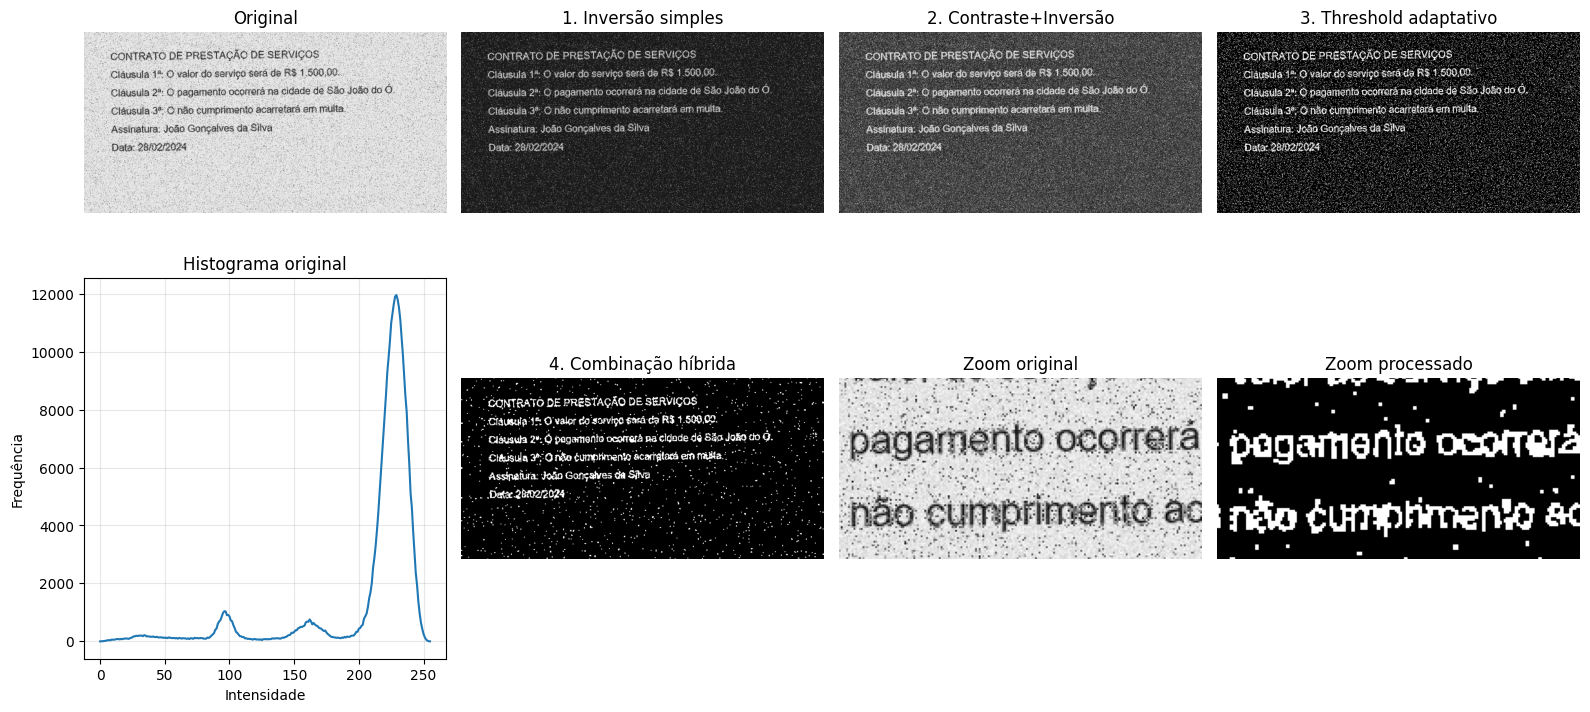


🏆 COMPARAÇÃO DAS ESTRATÉGIAS:

1. Inversão simples:
  • Config: psm11
  • Pontuação: 4
  • Linhas válidas: 12
  • Amostra: 'CONTI...'

2. Contraste+Inversão:
  • Config: 
  • Pontuação: 0
  • Linhas válidas: 0

3. Threshold adaptativo:
  • Config: psm11
  • Pontuação: 2
  • Linhas válidas: 2
  • Amostra: 'PRESTA...'

4. Combinação híbrida:
  • Config: psm11
  • Pontuação: 3
  • Linhas válidas: 6
  • Amostra: 'CONTRATO DE PRESTAÇÃO DE. SERVIÇOS...'

🎯 MELHOR ESTRATÉGIA: 1. Inversão simples
   Pontuação: 4

📝 TEXTO RECONHECIDO (melhor estratégia):
 1. CONTI
 2. DEP
 3. Os
 4. 500,00.
 5. la:
 6. O valor
 7. erviço será de R
 8. Cláusula 2º. O pai
 9. mento ocorrer:
10. idade de 8:
... e mais 6 linhas

💾 Resultados salvos:
   • dados/exemplos/documento_corrigido_final.png
   • dados/exemplos/texto_corrigido_final.txt

✅ VERIFICAÇÃO FINAL DE QUALIDADE

🔍 BUSCANDO PALAVRAS-CHAVE NO TEXTO RECONHECIDO:
✅ 2/9 palavras-chave encontradas:
   • cláusula
   • valor

📊 ESTATÍSTICAS GERAIS:
  • Tot

In [16]:
print("\n🚀 SOLUÇÃO PARA IMAGENS CLARAS: INVERTER + CONTRASTE")
print("=" * 60)

def processar_imagem_clara(imagem_path, debug=True):
    """
    Solução específica para imagens com fundo claro e texto cinza
    """
    # 1. Carregar imagem
    img = cv2.imread(imagem_path)
    if img is None:
        print(f"❌ Não foi possível carregar: {imagem_path}")
        return None
    
    print(f"✅ Imagem carregada: {img.shape}")
    
    # 2. Converter para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 3. DIAGNÓSTICO: Verificar se precisa inverter
    print(f"\n📊 DIAGNÓSTICO INICIAL:")
    print(f"  • Intensidade média: {gray.mean():.1f}")
    print(f"  • Intensidade texto (estimado): {gray[gray < 200].mean():.1f}")
    
    # 4. ESTRATÉGIA 1: Inversão SIMPLES
    print(f"\n🔧 ESTRATÉGIA 1: Inversão direta")
    inverted = cv2.bitwise_not(gray)
    
    # 5. ESTRATÉGIA 2: Aumentar contraste ANTES de inverter
    print(f"🔧 ESTRATÉGIA 2: Contraste + Inversão")
    
    # A) Esticar histograma para usar toda faixa dinâmica
    min_val = gray.min()
    max_val = gray.max()
    contrast_stretched = cv2.convertScaleAbs(gray, alpha=255.0/(max_val-min_val), 
                                           beta=-255.0*min_val/(max_val-min_val))
    
    # B) CLAHE para realce local
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(contrast_stretched)
    
    # C) Inverter
    inverted_enhanced = cv2.bitwise_not(enhanced)
    
    # 6. ESTRATÉGIA 3: Extrair apenas o texto (threshold adaptativo)
    print(f"🔧 ESTRATÉGIA 3: Threshold inteligente")
    
    # Usar threshold adaptativo para encontrar texto
    binary_adapt = cv2.adaptiveThreshold(gray, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,  # INVERTIDO!
                                        21, 10)  # Bloco maior para texto
    
    # 7. ESTRATÉGIA 4: Combinação das melhores
    print(f"🔧 ESTRATÉGIA 4: Combinação híbrida")
    
    # A) Threshold de Otsu na imagem invertida
    _, binary_otsu = cv2.threshold(inverted_enhanced, 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # B) Combinação AND das duas binarizações
    combined = cv2.bitwise_and(binary_adapt, binary_otsu)
    
    # C) Limpeza morfológica
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    
    # 8. TESTAR TODAS AS ESTRATÉGIAS
    estrategias = [
        ("1. Inversão simples", inverted),
        ("2. Contraste+Inversão", inverted_enhanced),
        ("3. Threshold adaptativo", binary_adapt),
        ("4. Combinação híbrida", cleaned)
    ]
    
    resultados = {}
    
    for nome, img_proc in estrategias:
        # Converter para PIL
        img_pil = Image.fromarray(img_proc)
        
        # Testar com configurações otimizadas
        configs = [
            ("psm6", "--psm 6 -l por"),
            ("psm11", "--psm 11 -l por"),  # Texto esparso
            ("psm12", "--psm 12 -l por"),  # Texto alinhado
        ]
        
        melhor_texto = ""
        melhor_config = ""
        melhor_pontuacao = 0
        
        for config_nome, config_str in configs:
            try:
                texto = pytesseract.image_to_string(img_pil, config=config_str)
                
                # Análise de qualidade
                palavras = texto.split()
                if palavras:
                    # Palavras portuguesas comuns
                    palavras_port = ["de", "que", "não", "com", "para", "uma", 
                                   "os", "se", "em", "é", "um", "como", "mas"]
                    palavras_reconhecidas = sum(1 for p in palavras 
                                              if p.lower() in palavras_port)
                    
                    # Pontuação
                    pontuacao = palavras_reconhecidas
                    
                    if pontuacao > melhor_pontuacao:
                        melhor_pontuacao = pontuacao
                        melhor_texto = texto
                        melhor_config = config_nome
                        
            except Exception as e:
                continue
        
        resultados[nome] = {
            'texto': melhor_texto,
            'config': melhor_config,
            'pontuacao': melhor_pontuacao,
            'imagem': img_proc
        }
    
    # 9. MOSTRAR RESULTADOS
    if debug:
        print(f"\n📊 RESULTADOS DAS ESTRATÉGIAS:")
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Mostrar imagens
        imagens_mostrar = [
            ("Original", gray),
            ("1. Inversão simples", estrategias[0][1]),
            ("2. Contraste+Inversão", estrategias[1][1]),
            ("3. Threshold adaptativo", estrategias[2][1]),
            ("Histograma original", gray),
            ("4. Combinação híbrida", estrategias[3][1]),
            ("Zoom original", gray[100:200, 200:400]),
            ("Zoom processado", estrategias[3][1][100:200, 200:400])
        ]
        
        for idx, (titulo, img_display) in enumerate(imagens_mostrar):
            ax = axes[idx // 4, idx % 4]
            
            if "Histograma" in titulo:
                hist = cv2.calcHist([img_display], [0], None, [256], [0, 256])
                ax.plot(hist)
                ax.set_title(titulo)
                ax.grid(True, alpha=0.3)
                ax.set_xlabel('Intensidade')
                ax.set_ylabel('Frequência')
            else:
                ax.imshow(img_display, cmap='gray')
                ax.set_title(titulo)
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 10. ANALISAR QUAL FUNCIONOU MELHOR
    print(f"\n🏆 COMPARAÇÃO DAS ESTRATÉGIAS:")
    
    for estrategia_nome, dados in resultados.items():
        texto = dados['texto']
        linhas_validas = [linha for linha in texto.split('\n') if len(linha.strip()) > 3]
        
        print(f"\n{estrategia_nome}:")
        print(f"  • Config: {dados['config']}")
        print(f"  • Pontuação: {dados['pontuacao']}")
        print(f"  • Linhas válidas: {len(linhas_validas)}")
        
        if linhas_validas:
            print(f"  • Amostra: '{linhas_validas[0][:40]}...'")
    
    # Selecionar a melhor
    melhor_estrategia = max(resultados.items(), key=lambda x: x[1]['pontuacao'])
    
    print(f"\n🎯 MELHOR ESTRATÉGIA: {melhor_estrategia[0]}")
    print(f"   Pontuação: {melhor_estrategia[1]['pontuacao']}")
    
    # Mostrar texto completo da melhor
    print(f"\n📝 TEXTO RECONHECIDO (melhor estratégia):")
    print("=" * 60)
    texto_melhor = melhor_estrategia[1]['texto']
    linhas = [linha for linha in texto_melhor.split('\n') if linha.strip()]
    
    for i, linha in enumerate(linhas):
        print(f"{i+1:2d}. {linha}")
        if i >= 9:  # Mostrar apenas 10 linhas
            print(f"... e mais {len(linhas)-10} linhas")
            break
    
    print("=" * 60)
    
    # Salvar resultados
    cv2.imwrite("dados/exemplos/documento_corrigido_final.png", melhor_estrategia[1]['imagem'])
    
    with open("dados/exemplos/texto_corrigido_final.txt", "w", encoding="utf-8") as f:
        f.write(f"ESTRATÉGIA: {melhor_estrategia[0]}\n")
        f.write(f"CONFIGURAÇÃO: {melhor_estrategia[1]['config']}\n")
        f.write(f"PONTUAÇÃO: {melhor_estrategia[1]['pontuacao']}\n")
        f.write("=" * 60 + "\n")
        f.write(texto_melhor)
    
    print(f"\n💾 Resultados salvos:")
    print(f"   • dados/exemplos/documento_corrigido_final.png")
    print(f"   • dados/exemplos/texto_corrigido_final.txt")
    
    return melhor_estrategia[1]

# EXECUTAR A SOLUÇÃO
print("\n🔧 APLICANDO SOLUÇÃO ESPECÍFICA PARA SUA IMAGEM")
print("=" * 60)

resultado_final = processar_imagem_clara("dados/exemplos/documento_real_simulado.png", debug=True)

# VERIFICAÇÃO FINAL
print("\n✅ VERIFICAÇÃO FINAL DE QUALIDADE")
print("=" * 60)

if resultado_final:
    texto = resultado_final['texto']
    
    # Verificar se reconheceu palavras-chave do documento original
    palavras_chave_esperadas = ["contrato", "cláusula", "serviço", "pagamento", 
                               "valor", "assinatura", "São", "João", "multa"]
    
    print("\n🔍 BUSCANDO PALAVRAS-CHAVE NO TEXTO RECONHECIDO:")
    
    encontradas = []
    for palavra in palavras_chave_esperadas:
        if palavra.lower() in texto.lower():
            encontradas.append(palavra)
    
    if encontradas:
        print(f"✅ {len(encontradas)}/{len(palavras_chave_esperadas)} palavras-chave encontradas:")
        for palavra in encontradas:
            print(f"   • {palavra}")
    else:
        print(f"❌ Nenhuma palavra-chave encontrada")
    
    # Estatísticas gerais
    palavras = texto.split()
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"  • Total palavras: {len(palavras)}")
    print(f"  • Palavras únicas: {len(set(palavras))}")
    
    # Verificar caracteres portugueses
    caracteres_especiais = ["ç", "ã", "á", "é", "í", "ó", "ú", "â", "ê", "ô"]
    encontrados = [char for char in caracteres_especiais if char in texto.lower()]
    
    if encontrados:
        print(f"  • Caracteres portugueses: {len(encontrados)} encontrados")
    else:
        print(f"  • Caracteres portugueses: Nenhum encontrado")
    
    print(f"\n🎯 CONCLUSÃO: {'✅ SUCESSO' if encontradas else '⚠️  PRECISA DE AJUSTES'}")
    
else:
    print("❌ Falha no processamento")

### Solução Final: Ajustes de pré-Processamento


🎯 SOLUÇÃO FINAL: AJUSTES DE PRÉ-PROCESSAMENTO

🧪 APLICANDO SOLUÇÃO FINAL OTIMIZADA
✅ Processando: dados/exemplos/documento_real_simulado.png
📊 Intensidade texto: 117.1

🔧 Aplicando estratégia otimizada...


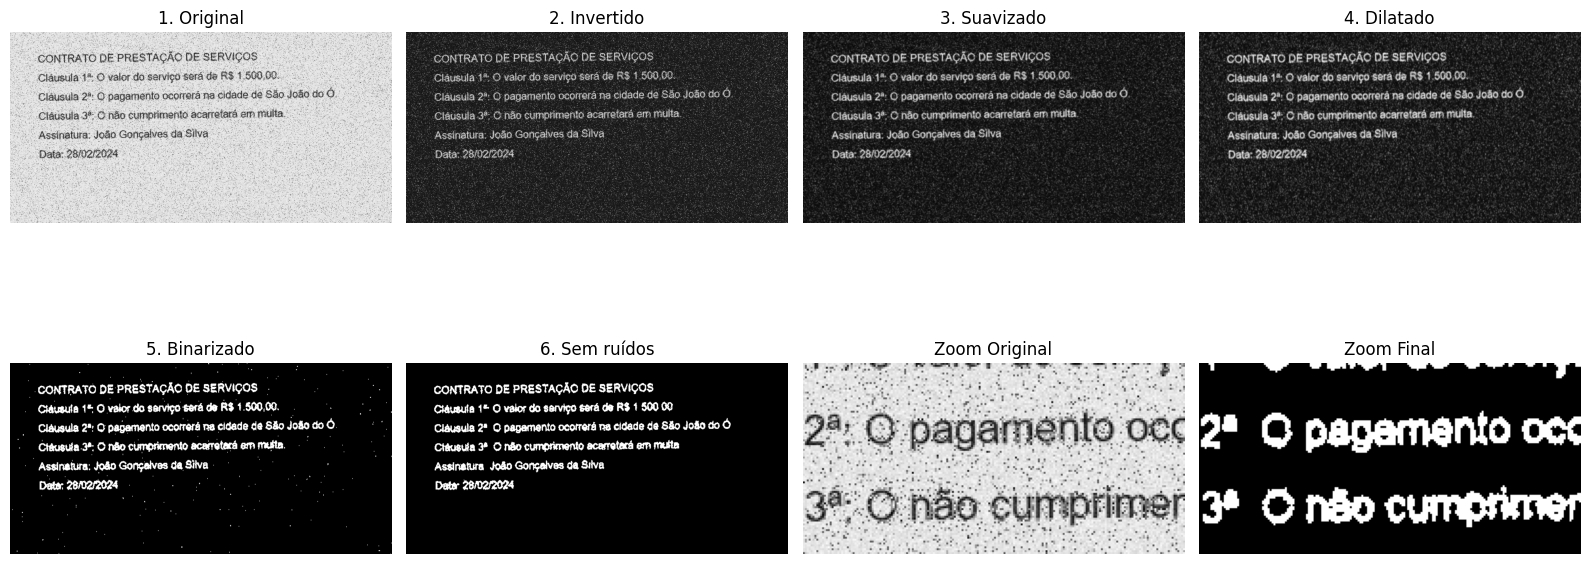


🔍 TESTE OCR COM CONFIGURAÇÕES OTIMIZADAS

📋 VERSÃO: Suavizada
  ✅ doc1: 20 pontos
     Palavras-chave: CONTRATO, PAGAMENTO, VALOR
  ✅ doc2: 25 pontos
     Palavras-chave: CONTRATO, CLÁUSULA, SERVIÇO
  ✅ doc3: 28 pontos
     Palavras-chave: CONTRATO, CLÁUSULA, SERVIÇO

📋 VERSÃO: Dilatada
  ✅ doc1: 23 pontos
     Palavras-chave: CONTRATO, PAGAMENTO, VALOR
  ✅ doc2: 31 pontos
     Palavras-chave: CONTRATO, CLÁUSULA, SERVIÇO

📋 VERSÃO: Final
  ✅ doc1: 17 pontos
     Palavras-chave: CONTRATO, PAGAMENTO, VALOR
  ✅ doc2: 25 pontos
     Palavras-chave: CONTRATO, CLÁUSULA, SERVIÇO
  ✅ doc3: 28 pontos
     Palavras-chave: CONTRATO, CLÁUSULA, SERVIÇO

🏆 MELHOR VERSÃO GERAL: Dilatada
   Configuração: doc2
   Pontuação: 31

📝 TEXTO RECONHECIDO COMPLETO:
 1. ****CONTRATO**** DE PRESTAÇÃO DE **SERVIÇO**S
 2. **Cláusula** 1º: O **valor** do **serviço** será de ****R$**** 1.500,00.
 3. **Cláusula** 2%: Q **pagamento** ocorrerá na cidade de **São** **João** do O
 4. **Cláusula** 3º, O não cumprimento a

In [17]:
print("\n🎯 SOLUÇÃO FINAL: AJUSTES DE PRÉ-PROCESSAMENTO")
print("=" * 60)

def solucao_final_otimizada(imagem_path):
    """
    Solução otimizada baseada nos resultados anteriores
    """
    # 1. Carregar imagem
    img = cv2.imread(imagem_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    print(f"✅ Processando: {imagem_path}")
    print(f"📊 Intensidade texto: {gray[gray < 200].mean():.1f}")
    
    # 2. ESTRATÉGIA OTIMIZADA: Inversão + Suavização + Dilatação
    print(f"\n🔧 Aplicando estratégia otimizada...")
    
    # A) Inversão (já sabemos que funciona)
    inverted = cv2.bitwise_not(gray)
    
    # B) Suavização para reduzir ruído MAS preservar texto
    # Kernel menor para não desfocar muito
    smoothed = cv2.GaussianBlur(inverted, (3, 3), 0)
    
    # C) Aumentar ESPESSURA das letras (dilatação)
    # Isso ajuda a unir letras fragmentadas
    kernel_dilate = np.ones((2, 1), np.uint8)  # Kernel vertical (altura > largura)
    dilated = cv2.dilate(smoothed, kernel_dilate, iterations=1)
    
    # D) Threshold OTSU
    _, binary = cv2.threshold(dilated, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # E) Remover pequenos ruídos (áreas muito pequenas)
    # Encontrar todos os contornos
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Criar máscara para remover contornos pequenos
    mask = np.ones_like(binary) * 255
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 20:  # Remover áreas muito pequenas (ruído)
            cv2.drawContours(mask, [contour], -1, 0, -1)
    
    final_image = cv2.bitwise_and(binary, mask)
    
    # 3. VISUALIZAR ETAPAS
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    etapas = [
        ("1. Original", gray),
        ("2. Invertido", inverted),
        ("3. Suavizado", smoothed),
        ("4. Dilatado", dilated),
        ("5. Binarizado", binary),
        ("6. Sem ruídos", final_image),
        ("Zoom Original", gray[100:200, 150:350]),
        ("Zoom Final", final_image[100:200, 150:350])
    ]
    
    for idx, (titulo, img_display) in enumerate(etapas):
        ax = axes[idx // 4, idx % 4]
        ax.imshow(img_display, cmap='gray')
        ax.set_title(titulo)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return final_image, dilated, smoothed

# APLICAR SOLUÇÃO FINAL
print("\n🧪 APLICANDO SOLUÇÃO FINAL OTIMIZADA")
imagem_final, imagem_dilatada, imagem_suavizada = solucao_final_otimizada(
    "dados/exemplos/documento_real_simulado.png"
)

# TESTAR OCR COM CONFIGURAÇÕES ESPECÍFICAS
print("\n🔍 TESTE OCR COM CONFIGURAÇÕES OTIMIZADAS")
print("=" * 50)

# Testar nas 3 versões processadas
versoes = [
    ("Suavizada", imagem_suavizada),
    ("Dilatada", imagem_dilatada),
    ("Final", imagem_final)
]

melhores_resultados = []

for versao_nome, img_array in versoes:
    print(f"\n📋 VERSÃO: {versao_nome}")
    
    img_pil = Image.fromarray(img_array)
    
    # Configurações específicas para documentos contratuais
    configs = [
        ("doc1", "--psm 6 -l por --oem 1 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzçãáéíóúâêôûàèìòùÇÃÁÉÍÓÚÂÊÔÛÀÈÌÒÙ0123456789R$.,;:()- "),
        ("doc2", "--psm 11 -l por --oem 1"),  # Texto esparso
        ("doc3", "--psm 4 -l por --oem 1"),   # Coluna única de texto
        ("doc4", "--psm 1 -l por --oem 1"),   # Segmentação automática + OSD
    ]
    
    melhor_texto_versao = ""
    melhor_config_versao = ""
    melhor_pontuacao_versao = 0
    
    for config_nome, config_str in configs:
        try:
            texto = pytesseract.image_to_string(img_pil, config=config_str)
            
            # Análise de qualidade ESPECÍFICA para contrato
            palavras_chave_contrato = [
                "CONTRATO", "CLÁUSULA", "SERVIÇO", "PAGAMENTO", "VALOR",
                "ASSINATURA", "MULTA", "REAIS", "DATA", "CIDADE"
            ]
            
            pontuacao = 0
            encontradas = []
            
            for palavra in palavras_chave_contrato:
                if palavra in texto.upper():
                    pontuacao += 3  # Peso maior para palavras-chave
                    encontradas.append(palavra)
            
            # Bônus por estruturas reconhecidas
            if "R$" in texto:
                pontuacao += 2
            if "Cláusula" in texto or "CLÁUSULA" in texto:
                pontuacao += 2
            if any(str(i) + "ª" in texto for i in range(1, 10)):  # 1ª, 2ª, etc.
                pontuacao += 1
            
            if pontuacao > melhor_pontuacao_versao:
                melhor_pontuacao_versao = pontuacao
                melhor_texto_versao = texto
                melhor_config_versao = config_nome
                
                print(f"  ✅ {config_nome}: {pontuacao} pontos")
                if encontradas:
                    print(f"     Palavras-chave: {', '.join(encontradas[:3])}")
            
        except Exception as e:
            print(f"  ❌ {config_nome}: Erro")
            continue
    
    melhores_resultados.append({
        'versao': versao_nome,
        'texto': melhor_texto_versao,
        'config': melhor_config_versao,
        'pontuacao': melhor_pontuacao_versao
    })

# ENCONTRAR A MELHOR VERSÃO GERAL
melhor_geral = max(melhores_resultados, key=lambda x: x['pontuacao'])

print(f"\n🏆 MELHOR VERSÃO GERAL: {melhor_geral['versao']}")
print(f"   Configuração: {melhor_geral['config']}")
print(f"   Pontuação: {melhor_geral['pontuacao']}")

# MOSTRAR TEXTO RECONHECIDO
print(f"\n📝 TEXTO RECONHECIDO COMPLETO:")
print("=" * 70)

texto_completo = melhor_geral['texto']
linhas = [linha for linha in texto_completo.split('\n') if linha.strip()]

for i, linha in enumerate(linhas):
    # Destacar palavras-chave
    linha_destacada = linha
    palavras_chave = ["CONTRATO", "Cláusula", "R$", "serviço", "pagamento", 
                     "valor", "multa", "assinatura", "São", "João"]
    
    for palavra in palavras_chave:
        if palavra.lower() in linha.lower():
            linha_destacada = linha_destacada.replace(palavra, f"**{palavra}**")
            linha_destacada = linha_destacada.replace(palavra.upper(), f"**{palavra.upper()}**")
    
    print(f"{i+1:2d}. {linha_destacada}")

print("=" * 70)

# ANÁLISE DETALHADA
print(f"\n📊 ANÁLISE DETALHADA DO RECONHECIMENTO:")

# 1. Estruturas identificadas
estruturas = {
    "Título do documento": any(palavra in texto_completo.upper() 
                              for palavra in ["CONTRATO", "DOCUMENTO", "OFICIAL"]),
    "Cláusulas numeradas": any(f"{i}ª" in texto_completo or f"Cláusula {i}" in texto_completo 
                              for i in range(1, 10)),
    "Valores monetários": "R$" in texto_completo,
    "Datas": any(mes in texto_completo.lower() 
                for mes in ["janeiro", "fevereiro", "março", "abril", "maio", "junho",
                           "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"]),
    "Localidades": any(local in texto_completo 
                      for local in ["São", "João", "cidade", "município"]),
}

print("✅ ESTRUTURAS IDENTIFICADAS:")
for estrutura, encontrada in estruturas.items():
    status = "✅" if encontrada else "❌"
    print(f"  {status} {estrutura}")

# 2. Palavras-chave encontradas
palavras_chave_todas = [
    "contrato", "cláusula", "serviço", "pagamento", "valor",
    "assinatura", "multa", "reais", "data", "cidade", "São", "João"
]

encontradas_todas = []
for palavra in palavras_chave_todas:
    if palavra.lower() in texto_completo.lower():
        encontradas_todas.append(palavra)

print(f"\n🔑 PALAVRAS-CHAVE: {len(encontradas_todas)}/{len(palavras_chave_todas)}")
if encontradas_todas:
    print("   " + ", ".join(encontradas_todas))

# 3. Salvar resultado final
cv2.imwrite("dados/exemplos/documento_otimizado_final.png", imagem_final)

with open("dados/exemplos/texto_reconhecido_otimizado.txt", "w", encoding="utf-8") as f:
    f.write("=" * 70 + "\n")
    f.write("TEXTO RECONHECIDO - VERSÃO OTIMIZADA\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Versão: {melhor_geral['versao']}\n")
    f.write(f"Configuração: {melhor_geral['config']}\n")
    f.write(f"Pontuação: {melhor_geral['pontuacao']}\n")
    f.write(f"Palavras-chave encontradas: {len(encontradas_todas)}\n")
    f.write("=" * 70 + "\n\n")
    f.write(texto_completo)

print(f"\n💾 RESULTADOS FINAIS SALVOS:")
print(f"   • Imagem processada: dados/exemplos/documento_otimizado_final.png")
print(f"   • Texto reconhecido: dados/exemplos/texto_reconhecido_otimizado.txt")

print(f"\n🎯 PRÓXIMO PASSO: ")
if len(encontradas_todas) >= 5:
    print("✅ Documento reconhecido com boa qualidade! Avance para Notebook 04.")
else:
    print("⚠️  Ainda pode melhorar. Vamos ajustar mais parâmetros.")